# GRU4Rec con Dataset Yoochoose

Este notebook implementa GRU4Rec (Gated Recurrent Units) entrenado en el dataset Yoochoose del RecSys Challenge 2015.

**Arquitectura**: Unidades Recurrentes con Compuertas (GRU) para recomendación secuencial  
**Dataset**: Yoochoose (sesiones de e-commerce)  
**Métricas**: Recall@K, MRR@K, ILD@K, Popularity Bias@K

## 🔧 Instalación de Dependencias

In [1]:
# Instalación de dependencias necesarias
!pip install torch numpy pandas scikit-learn tqdm matplotlib seaborn psutil

# Imports principales
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import gc
import psutil
import datetime as dt
import os
import time
import warnings
warnings.filterwarnings('ignore')

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Dispositivo: {device}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 Memoria GPU: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

print("✅ Dependencias instaladas y configuradas correctamente")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

## 📊 Descarga y Preprocesamiento del Dataset Yoochoose

🔄 Descargando dataset Yoochoose...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  273M  100  273M    0     0  62.4M      0  0:00:04  0:00:04 --:--:-- 62.4M

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 287211932 bytes (274 MiB)

Extracting archive: data.7z
--
Path = data.7z
Type = 7z
Physical Size = 287211932
Headers Size = 255
Method = LZMA:24
Solid = +
Blocks = 2

  0%      0% - yoochoose-buys.dat                           1% - yoochoose-buys.dat                           2% - yoochoose-buys.dat                    

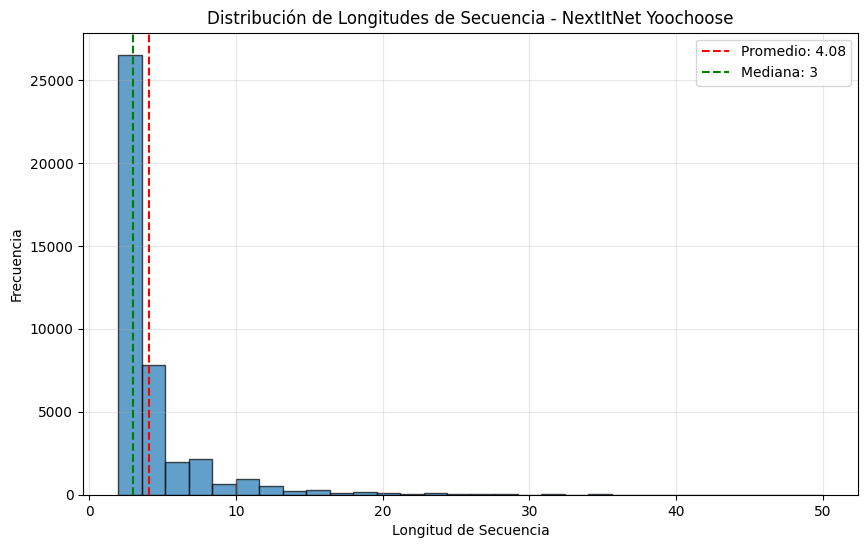

✅ Dataset Yoochoose procesado exitosamente:
   41,832 secuencias de entrenamiento
   15,044 secuencias de test
   Vocabulario size: 12339


In [2]:
# Descargar y extraer dataset Yoochoose
print("🔄 Descargando dataset Yoochoose...")

# Crear directorios necesarios
!mkdir -p data
!mkdir -p rsc15

# Descargar dataset
!curl https://s3-eu-west-1.amazonaws.com/yc-rdata/yoochoose-data.7z --output data.7z

# Extraer dataset
!7z e data.7z -o./rsc15
!rm data.7z

print("✅ Dataset Yoochoose descargado y extraído")

def load_and_preprocess_yoochoose(src_path='./rsc15/', use_fraction=64, max_seq_len=50):
    """
    Carga y preprocesa el dataset Yoochoose de forma optimizada
    """
    print("🔧 Procesando dataset Yoochoose...")

    # Cargar datos
    data = pd.read_csv(src_path + 'yoochoose-clicks.dat', sep=',', header=None,
                      usecols=[0,1,2], dtype={0:np.int32, 1:str, 2:np.int64})
    data.columns = ['SessionId', 'TimeStr', 'ItemId']

    print(f"📊 Estadísticas iniciales:")
    print(f"   Total eventos: {len(data):,}")
    print(f"   Sesiones únicas: {data['SessionId'].nunique():,}")
    print(f"   Items únicos: {data['ItemId'].nunique():,}")

    # Agregar timestamp
    data['Time'] = data.TimeStr.apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ').timestamp())
    del(data['TimeStr'])

    # Filtros estándar de Yoochoose
    session_lengths = data.groupby('SessionId').size()
    data = data[np.in1d(data.SessionId, session_lengths[session_lengths>1].index)]

    item_supports = data.groupby('ItemId').size()
    data = data[np.in1d(data.ItemId, item_supports[item_supports>=5].index)]

    session_lengths = data.groupby('SessionId').size()
    data = data[np.in1d(data.SessionId, session_lengths[session_lengths>=2].index)]

    # División temporal: test = último día
    tmax = data.Time.max()
    session_max_times = data.groupby('SessionId').Time.max()

    session_train = session_max_times[session_max_times < tmax-86400].index
    train = data[np.in1d(data.SessionId, session_train)]

    session_test = session_max_times[session_max_times >= tmax-86400].index
    test = data[np.in1d(data.SessionId, session_test)]
    test = test[np.in1d(test.ItemId, train.ItemId)]
    tslength = test.groupby('SessionId').size()
    test = test[np.in1d(test.SessionId, tslength[tslength>=2].index)]

    # Usar fracción de datos para entrenamiento
    if use_fraction:
        print(f"🎯 Usando 1/{use_fraction} de los datos de entrenamiento...")
        length = len(train['ItemId'])
        first_session = train.iloc[length - length//use_fraction].SessionId
        train = train.loc[train['SessionId'] >= first_session]

    print(f"📊 Datos procesados:")
    print(f"   Train: {len(train):,} eventos, {train.SessionId.nunique():,} sesiones")
    print(f"   Test: {len(test):,} eventos, {test.SessionId.nunique():,} sesiones")

    # Convertir a secuencias
    def to_sequences(df):
        sessions = df.sort_values(['SessionId', 'Time']).groupby('SessionId')['ItemId'].apply(list)
        sequences = [seq for seq in sessions if len(seq) >= 2 and len(seq) <= max_seq_len]
        return sequences

    train_sequences = to_sequences(train)
    test_sequences = to_sequences(test)

    # Crear mapeo de items
    all_items = []
    for seq in train_sequences:
        all_items.extend(seq)

    unique_items = sorted(set(all_items))
    item_to_idx = {item: idx + 1 for idx, item in enumerate(unique_items)}
    idx_to_item = {idx: item for item, idx in item_to_idx.items()}

    # Convertir a índices
    train_sequences_idx = [[item_to_idx[item] for item in seq] for seq in train_sequences]

    # Filtrar test sequences para items conocidos
    test_sequences_filtered = []
    for seq in test_sequences:
        filtered_seq = [item_to_idx[item] for item in seq if item in item_to_idx]
        if len(filtered_seq) >= 2:
            test_sequences_filtered.append(filtered_seq)

    print(f"📊 Secuencias finales:")
    print(f"   Train: {len(train_sequences_idx):,} secuencias")
    print(f"   Test: {len(test_sequences_filtered):,} secuencias")
    print(f"   Vocabulario: {len(item_to_idx):,} items únicos")

    # Estadísticas de distribución
    seq_lengths = [len(seq) for seq in train_sequences_idx]
    plt.figure(figsize=(10, 6))
    plt.hist(seq_lengths, bins=30, alpha=0.7, edgecolor='black')
    plt.axvline(np.mean(seq_lengths), color='red', linestyle='--',
                label=f'Promedio: {np.mean(seq_lengths):.2f}')
    plt.axvline(np.median(seq_lengths), color='green', linestyle='--',
                label=f'Mediana: {np.median(seq_lengths):.0f}')
    plt.xlabel('Longitud de Secuencia')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Longitudes de Secuencia - NextItNet Yoochoose')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return train_sequences_idx, test_sequences_filtered, item_to_idx, idx_to_item

# Procesar datos
train_sequences, test_sequences, item_to_idx, idx_to_item = load_and_preprocess_yoochoose(
    use_fraction=64  # Cambiar a None para dataset completo
)

print(f"✅ Dataset Yoochoose procesado exitosamente:")
print(f"   {len(train_sequences):,} secuencias de entrenamiento")
print(f"   {len(test_sequences):,} secuencias de test")
print(f"   Vocabulario size: {len(item_to_idx) + 1}")  # +1 para padding


## 🔄 División del Dataset y Creación de DataLoaders

In [3]:
class SequentialDataset(Dataset):
    """Dataset optimizado para secuencias con padding dinámico"""

    def __init__(self, sequences, max_len=50):
        self.sequences = sequences
        self.max_len = max_len

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]

        # Crear input y target sequences
        if len(seq) <= self.max_len:
            # Secuencia completa
            input_seq = seq[:-1]  # Todos menos el último
            target_seq = seq[1:]  # Todos menos el primero
        else:
            # Truncar secuencia
            input_seq = seq[:self.max_len]
            target_seq = seq[1:self.max_len+1]

        # Padding
        input_padded = [0] * (self.max_len - len(input_seq)) + input_seq
        target_padded = [0] * (self.max_len - len(target_seq)) + target_seq

        return torch.tensor(input_padded, dtype=torch.long), torch.tensor(target_padded, dtype=torch.long)

# Las secuencias ya están divididas por Yoochoose (temporal split)
print(f"📊 División del dataset (temporal):")
print(f"   Entrenamiento: {len(train_sequences):,} secuencias")
print(f"   Test: {len(test_sequences):,} secuencias")

# Calcular estadísticas para el max_len apropiado
all_lengths = [len(seq) for seq in train_sequences]
max_len_95 = int(np.percentile(all_lengths, 95))
max_len_99 = int(np.percentile(all_lengths, 99))

print(f"📏 Análisis de longitudes:")
print(f"   Máximo: {max(all_lengths)}")
print(f"   Percentil 95: {max_len_95}")
print(f"   Percentil 99: {max_len_99}")

# Usar percentil 95 para equilibrar memoria y coverage
MAX_LEN = max_len_95
print(f"   Usando max_len = {MAX_LEN}")

# Crear datasets
train_dataset = SequentialDataset(train_sequences, max_len=MAX_LEN)
test_dataset = SequentialDataset(test_sequences, max_len=MAX_LEN)

# Crear DataLoaders con batch sizes razonables
BATCH_SIZE = 32  # Reducido para evitar problemas de memoria
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"✅ DataLoaders creados:")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Batches de entrenamiento: {len(train_loader)}")
print(f"   Batches de prueba: {len(test_loader)}")
print(f"   Max length: {MAX_LEN}")

# Ejemplo de un batch
sample_input, sample_target = next(iter(train_loader))
print(f"\n📝 Ejemplo de batch:")
print(f"   Input shape: {sample_input.shape}")
print(f"   Target shape: {sample_target.shape}")
print(f"   Vocabulario size: {len(item_to_idx) + 1}")  # +1 para padding


📊 División del dataset (temporal):
   Entrenamiento: 41,832 secuencias
   Test: 15,044 secuencias
📏 Análisis de longitudes:
   Máximo: 50
   Percentil 95: 11
   Percentil 99: 21
   Usando max_len = 11
✅ DataLoaders creados:
   Batch size: 32
   Batches de entrenamiento: 1308
   Batches de prueba: 471
   Max length: 11

📝 Ejemplo de batch:
   Input shape: torch.Size([32, 11])
   Target shape: torch.Size([32, 11])
   Vocabulario size: 12339


## 🧠 Implementación de GRU4Rec

GRU4Rec utiliza Gated Recurrent Units (GRU) para modelar secuencias de ítems en sistemas de recomendación, siendo especialmente efectivo para recomendaciones basadas en sesiones.


In [4]:
class GRU4Rec(nn.Module):
    """
    GRU4Rec: Session-based Recommendations with Recurrent Neural Networks

    Implementación optimizada de GRU4Rec para recomendación secuencial
    """

    def __init__(self, num_items, embedding_dim=64, hidden_dim=128, num_layers=1, dropout=0.1):
        super(GRU4Rec, self).__init__()

        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Embedding layer para items
        self.item_embedding = nn.Embedding(num_items, embedding_dim, padding_idx=0)

        # GRU layers
        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Output projection layer
        self.output_projection = nn.Linear(hidden_dim, num_items)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        """Initialize model weights siguiendo las mejores prácticas"""
        for module in self.modules():
            if isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, mean=0, std=0.01)
                if module.padding_idx is not None:
                    module.weight.data[module.padding_idx].fill_(0)
            elif isinstance(module, nn.GRU):
                for name, param in module.named_parameters():
                    if 'weight_ih' in name:
                        nn.init.xavier_uniform_(param.data)
                    elif 'weight_hh' in name:
                        nn.init.orthogonal_(param.data)
                    elif 'bias' in name:
                        param.data.fill_(0)
            elif isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

    def forward(self, x):
        """
        Forward pass

        Args:
            x: Input tensor of shape (batch_size, seq_len)

        Returns:
            Output tensor of shape (batch_size, seq_len, num_items)
        """
        # Embedding
        embedded = self.item_embedding(x)  # (batch_size, seq_len, embedding_dim)

        # GRU forward pass
        gru_output, _ = self.gru(embedded)  # (batch_size, seq_len, hidden_dim)

        # Apply dropout
        gru_output = self.dropout(gru_output)

        # Project to item space
        output = self.output_projection(gru_output)  # (batch_size, seq_len, num_items)

        return output

# Crear modelo GRU4Rec
VOCAB_SIZE = len(item_to_idx) + 1  # +1 para padding
EMBEDDING_DIM = 64
HIDDEN_DIM = 128    # Tamaño típico para GRU4Rec
NUM_LAYERS = 1      # Empezar con 1 capa
DROPOUT = 0.1

model = GRU4Rec(
    num_items=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)

# Mostrar arquitectura del modelo
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"🏗️  Arquitectura de GRU4Rec:")
print(f"   Vocabulario: {VOCAB_SIZE:,} items")
print(f"   Embedding dim: {EMBEDDING_DIM}")
print(f"   Hidden dim: {HIDDEN_DIM}")
print(f"   Número de capas GRU: {NUM_LAYERS}")
print(f"   Dropout: {DROPOUT}")
print(f"   Parámetros totales: {total_params:,}")
print(f"   Parámetros entrenables: {trainable_params:,}")

# Probar forward pass
with torch.no_grad():
    sample_input = sample_input.to(device)
    sample_output = model(sample_input)
    print(f"\n✅ Forward pass exitoso:")
    print(f"   Input shape: {sample_input.shape}")
    print(f"   Output shape: {sample_output.shape}")
    print(f"   Memoria GPU usada: {torch.cuda.memory_allocated(device) / 1024**2:.1f} MB" if torch.cuda.is_available() else "   CPU usado")


🏗️  Arquitectura de GRU4Rec:
   Vocabulario: 12,339 items
   Embedding dim: 64
   Hidden dim: 128
   Número de capas GRU: 1
   Dropout: 0.1
   Parámetros totales: 2,455,923
   Parámetros entrenables: 2,455,923

✅ Forward pass exitoso:
   Input shape: torch.Size([32, 11])
   Output shape: torch.Size([32, 11, 12339])
   Memoria GPU usada: 34.1 MB


## 🚀 Entrenamiento del Modelo

🚀 Iniciando entrenamiento de GRU4Rec...
   Epochs: 10
   Learning rate: 0.001
   Batches por epoch: 1308


Epoch 1/10: 100%|██████████| 1308/1308 [00:08<00:00, 161.31it/s, Loss=7.1039, Avg Loss=7.3052]


   Epoch 1/10 completado - Loss: 7.3052


Epoch 2/10: 100%|██████████| 1308/1308 [00:12<00:00, 107.65it/s, Loss=7.1272, Avg Loss=6.2985]


   Epoch 2/10 completado - Loss: 6.2985


Epoch 3/10: 100%|██████████| 1308/1308 [00:08<00:00, 147.33it/s, Loss=5.4211, Avg Loss=5.6049]


   Epoch 3/10 completado - Loss: 5.6049


Epoch 4/10: 100%|██████████| 1308/1308 [00:07<00:00, 176.35it/s, Loss=5.2127, Avg Loss=5.1242]


   Epoch 4/10 completado - Loss: 5.1242


Epoch 5/10: 100%|██████████| 1308/1308 [00:07<00:00, 174.27it/s, Loss=5.6037, Avg Loss=4.7340]


   Epoch 5/10 completado - Loss: 4.7340


Epoch 6/10: 100%|██████████| 1308/1308 [00:07<00:00, 171.25it/s, Loss=5.2572, Avg Loss=4.4198]


   Epoch 6/10 completado - Loss: 4.4198


Epoch 7/10: 100%|██████████| 1308/1308 [00:07<00:00, 182.73it/s, Loss=3.1622, Avg Loss=4.1491]


   Epoch 7/10 completado - Loss: 4.1491


Epoch 8/10: 100%|██████████| 1308/1308 [00:07<00:00, 167.93it/s, Loss=4.0342, Avg Loss=3.9169]


   Epoch 8/10 completado - Loss: 3.9169


Epoch 9/10: 100%|██████████| 1308/1308 [00:07<00:00, 183.30it/s, Loss=4.4912, Avg Loss=3.7131]


   Epoch 9/10 completado - Loss: 3.7131


Epoch 10/10: 100%|██████████| 1308/1308 [00:07<00:00, 167.80it/s, Loss=3.9237, Avg Loss=3.5335]


   Epoch 10/10 completado - Loss: 3.5335


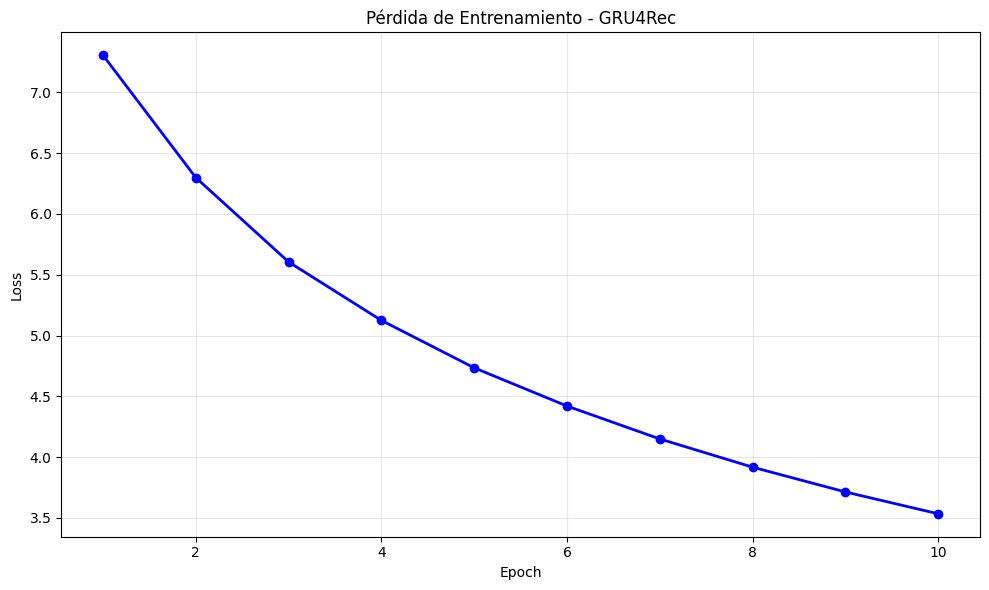

✅ Entrenamiento completado!
   Loss final: 3.5335
   Mejor loss: 3.5335
💾 Modelo guardado como 'gru4rec_yc.pth'


In [5]:
def train_gru4rec(model, train_loader, num_epochs=10, learning_rate=0.001):
    """
    Entrena GRU4Rec
    """
    print(f"🚀 Iniciando entrenamiento de GRU4Rec...")
    print(f"   Epochs: {num_epochs}")
    print(f"   Learning rate: {learning_rate}")
    print(f"   Batches por epoch: {len(train_loader)}")

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignorar padding (index 0)

    # Scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                           factor=0.5, patience=2, verbose=True)

    model.train()

    # Listas para tracking
    epoch_losses = []

    for epoch in range(num_epochs):
        total_loss = 0.0
        num_batches = 0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch_idx, (input_seq, target_seq) in enumerate(progress_bar):
            input_seq = input_seq.to(device)
            target_seq = target_seq.to(device)

            # Forward pass
            optimizer.zero_grad()
            logits = model(input_seq)  # (batch_size, seq_len, vocab_size)

            # Reshape for loss calculation
            logits = logits.reshape(-1, logits.size(-1))  # (batch_size * seq_len, vocab_size)
            target_seq = target_seq.reshape(-1)  # (batch_size * seq_len,)

            # Calculate loss
            loss = criterion(logits, target_seq)

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            # Update metrics
            total_loss += loss.item()
            num_batches += 1

            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Avg Loss': f'{total_loss/num_batches:.4f}'
            })

            # Limpieza de memoria
            if batch_idx % 50 == 0:
                torch.cuda.empty_cache() if torch.cuda.is_available() else None

        # Métricas del epoch
        avg_loss = total_loss / num_batches
        epoch_losses.append(avg_loss)

        print(f"   Epoch {epoch+1}/{num_epochs} completado - Loss: {avg_loss:.4f}")

        # Update scheduler
        scheduler.step(avg_loss)

        # Limpieza de memoria al final del epoch
        gc.collect()
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

    # Graficar pérdidas de entrenamiento
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), epoch_losses, 'b-', linewidth=2, marker='o')
    plt.title('Pérdida de Entrenamiento - GRU4Rec')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"✅ Entrenamiento completado!")
    print(f"   Loss final: {epoch_losses[-1]:.4f}")
    print(f"   Mejor loss: {min(epoch_losses):.4f}")

    return epoch_losses

training_losses = train_gru4rec(
    model=model,
    train_loader=train_loader,
    num_epochs=10,
    learning_rate=0.001
)

# Guardar modelo entrenado
torch.save(model.state_dict(), 'gru4rec_yc.pth')
print("💾 Modelo guardado como 'gru4rec_yc.pth'")


## 📊 Evaluación Optimizada (Sin Problemas de Memoria)

Esta sección implementa una evaluación eficiente que calcula todas las métricas on-the-fly, evitando almacenar predicciones completas en memoria.


In [6]:
def evaluate_model_memory_efficient(model, test_loader, train_item_popularity, device,
                                   k_values=[5, 10, 20], max_samples_for_diversity=10000):
    """
    Evaluación optimizada para memoria que calcula métricas on-the-fly

    Args:
        model: Modelo GRU4Rec entrenado
        test_loader: DataLoader de prueba
        train_item_popularity: Diccionario con popularidad de items
        device: Dispositivo (CPU/GPU)
        k_values: Valores de k para evaluar (top-k)
        max_samples_for_diversity: Máximo número de muestras para diversidad (ahorro de memoria)

    Returns:
        Diccionario con todas las métricas
    """
    model.eval()

    # Inicializar contadores para cada k
    metrics = {}
    for k in k_values:
        metrics[k] = {
            'recall_hits': 0,
            'mrr_sum': 0.0,
            'recommendations': [],  # Solo guardamos top-k, no predicciones completas
            'total_predictions': 0
        }

    max_k = max(k_values)
    max_popularity = max(train_item_popularity.values()) if train_item_popularity else 1

    print(f"🔍 Evaluando modelo (optimizado para memoria)...")
    print(f"   Calculando métricas para k = {k_values}")
    print(f"   Máximo muestras para diversidad: {max_samples_for_diversity:,}")

    with torch.no_grad():
        batch_count = 0
        total_predictions = 0

        for input_seq, target_seq in tqdm(test_loader, desc="Evaluando"):
            input_seq = input_seq.to(device)
            target_seq = target_seq.to(device)

            # Predicciones del modelo
            logits = model(input_seq)  # (batch_size, seq_len, vocab_size)

            # Máscara para posiciones válidas (no padding)
            mask = target_seq != 0

            # Procesar cada secuencia en el batch
            for i in range(logits.size(0)):
                seq_logits = logits[i]  # (seq_len, vocab_size)
                seq_targets = target_seq[i]  # (seq_len,)
                seq_mask = mask[i]  # (seq_len,)

                # Procesar cada posición en la secuencia
                for j in range(seq_logits.size(0)):
                    if seq_mask[j]:  # Si no es padding
                        pred_scores = seq_logits[j]  # (vocab_size,)
                        true_item = seq_targets[j].item()

                        # Obtener top-max_k items (excluyendo padding idx=0)
                        # Evitamos recomendar el padding token
                        valid_scores = pred_scores[1:]  # Excluir padding (índice 0)
                        _, top_k_indices = torch.topk(valid_scores, max_k)
                        top_k_items = (top_k_indices + 1).cpu().tolist()  # +1 porque excluimos índice 0

                        # Calcular métricas para cada k
                        for k in k_values:
                            top_k_subset = top_k_items[:k]

                            # Recall@k y MRR@k
                            if true_item in top_k_subset:
                                metrics[k]['recall_hits'] += 1
                                rank = top_k_subset.index(true_item) + 1
                                metrics[k]['mrr_sum'] += 1.0 / rank

                            # Guardar recomendaciones para diversidad (con límite de memoria)
                            if len(metrics[k]['recommendations']) < max_samples_for_diversity:
                                metrics[k]['recommendations'].append(top_k_subset)

                            metrics[k]['total_predictions'] += 1

                        total_predictions += 1

            # Limpieza periódica de memoria
            batch_count += 1
            if batch_count % 50 == 0:
                torch.cuda.empty_cache() if torch.cuda.is_available() else None
                gc.collect()

    # Calcular métricas finales
    results = {}

    print(f"📊 Calculando métricas finales...")

    for k in k_values:
        total_preds = metrics[k]['total_predictions']

        # Recall@k y MRR@k
        recall_k = metrics[k]['recall_hits'] / total_preds if total_preds > 0 else 0.0
        mrr_k = metrics[k]['mrr_sum'] / total_preds if total_preds > 0 else 0.0

        # ILD (Diversidad) - Fórmula estándar con embeddings
        ild_k = calculate_intra_list_diversity_efficient(metrics[k]['recommendations'], model=model)

        # Popularity Bias - Versión eficiente
        pop_bias_k = calculate_popularity_bias_efficient(
            metrics[k]['recommendations'],
            train_item_popularity,
            max_popularity
        )

        # Almacenar resultados
        results[f'recall_{k}'] = recall_k
        results[f'mrr_{k}'] = mrr_k
        results[f'ild_{k}'] = ild_k
        results[f'popularity_bias_{k}'] = pop_bias_k

    # Limpieza final
    del metrics
    gc.collect()
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

    return results

def calculate_intra_list_diversity_efficient(recommendations_list, model=None):
    """
    Calcula la Intra-List Diversity (ILD) usando similitud coseno de embeddings

    Fórmula estándar: ILD(L) = (2 / (|L|(|L|-1))) * Σ(i<j) (1 - sim(i,j))

    Args:
        recommendations_list: Lista de listas de items recomendados
        model: Modelo con embeddings (NextItNet o GRU4Rec)

    Returns:
        float: Valor de ILD promedio
    """
    if not recommendations_list:
        return 0.0

    if model is None:
        raise ValueError("Se requiere un modelo con embeddings para calcular ILD")

    # Versión estándar con embeddings
    total_diversity = 0.0
    valid_sessions = 0

    # Obtener embeddings del modelo
    if hasattr(model, 'item_embedding'):
        embedding_layer = model.item_embedding
    elif hasattr(model, 'embedding'):
        embedding_layer = model.embedding
    else:
        raise ValueError("Se requiere un modelo con embeddings para calcular ILD")

    with torch.no_grad():
        for rec_list in recommendations_list:
            if len(rec_list) < 2:
                continue

            # Obtener embeddings de los items recomendados
            item_ids = torch.tensor(rec_list, dtype=torch.long)
            if torch.cuda.is_available():
                item_ids = item_ids.cuda()

            # Obtener embeddings (shape: [num_items, embedding_dim])
            embeddings = embedding_layer(item_ids)

            # Calcular similitud coseno entre todos los pares
            # Normalizar embeddings para usar producto punto como coseno
            embeddings_norm = F.normalize(embeddings, p=2, dim=1)

            # Matriz de similitud coseno
            similarity_matrix = torch.mm(embeddings_norm, embeddings_norm.t())

            # Calcular ILD usando la fórmula estándar
            num_items = len(rec_list)
            total_pairs = num_items * (num_items - 1) // 2

            if total_pairs == 0:
                continue

            # Sumar todas las similitudes de pares únicos (i < j)
            similarity_sum = 0.0
            for i in range(num_items):
                for j in range(i + 1, num_items):
                    similarity_sum += similarity_matrix[i, j].item()

            # ILD = (2 / (|L|(|L|-1))) * Σ(i<j) (1 - sim(i,j))
            diversity = (2.0 / (num_items * (num_items - 1))) * (total_pairs - similarity_sum)
            total_diversity += diversity
            valid_sessions += 1

    return total_diversity / valid_sessions if valid_sessions > 0 else 0.0

def calculate_popularity_bias_efficient(recommendations_list, item_popularity, max_popularity):
    """
    Calcula el sesgo hacia items populares de forma eficiente

    Popularity Bias mide cuánto el modelo tiende a recomendar items populares
    """
    if not recommendations_list or not item_popularity:
        return 0.0

    total_popularity = 0.0
    total_items = 0

    for rec_list in recommendations_list:
        for item_id in rec_list:
            if item_id in item_popularity:
                normalized_pop = item_popularity[item_id] / max_popularity
                total_popularity += normalized_pop
                total_items += 1

    return total_popularity / total_items if total_items > 0 else 0.0

def monitor_memory_usage():
    """Monitorea el uso actual de memoria"""
    memory = psutil.virtual_memory()
    print(f"💾 MEMORIA DEL SISTEMA:")
    print(f"   Total: {memory.total / (1024**3):.2f} GB")
    print(f"   Usada: {memory.used / (1024**3):.2f} GB ({memory.percent:.1f}%)")
    print(f"   Libre: {memory.available / (1024**3):.2f} GB")

    if torch.cuda.is_available():
        gpu_memory = torch.cuda.get_device_properties(0).total_memory
        gpu_allocated = torch.cuda.memory_allocated(0)
        gpu_cached = torch.cuda.memory_reserved(0)

        print(f"🎮 MEMORIA DE GPU:")
        print(f"   Total: {gpu_memory / (1024**3):.2f} GB")
        print(f"   Asignada: {gpu_allocated / (1024**3):.2f} GB")
        print(f"   En caché: {gpu_cached / (1024**3):.2f} GB")

# Monitorear memoria antes de evaluar
print("🔍 Estado de memoria antes de la evaluación:")
monitor_memory_usage()

print("✅ Funciones de evaluación optimizada cargadas")


🔍 Estado de memoria antes de la evaluación:
💾 MEMORIA DEL SISTEMA:
   Total: 12.67 GB
   Usada: 2.12 GB (19.3%)
   Libre: 10.22 GB
🎮 MEMORIA DE GPU:
   Total: 14.74 GB
   Asignada: 0.05 GB
   En caché: 0.09 GB
✅ Funciones de evaluación optimizada cargadas


In [7]:
# EJECUTAR EVALUACIÓN OPTIMIZADA
print("🚀 Iniciando evaluación completa de NextItNet...")

# Calcular popularidad de items del entrenamiento
print("📊 Calculando popularidad de items del entrenamiento...")
train_item_popularity = Counter()
for seq in train_sequences:
    train_item_popularity.update(seq)

print(f"   Items únicos en entrenamiento: {len(train_item_popularity):,}")
print(f"   Item más popular: {max(train_item_popularity.values()):,} apariciones")

# Ejecutar evaluación optimizada
results = evaluate_model_memory_efficient(
    model=model,
    test_loader=test_loader,
    train_item_popularity=dict(train_item_popularity),
    device=device,
    k_values=[5, 10, 20],
    max_samples_for_diversity=10000  # Límite para evitar problemas de memoria
)

# Mostrar resultados completos
print("\n" + "="*70)
print("📋 RESULTADOS COMPLETOS DE NEXTITNET - RETAILROCKET")
print("="*70)

print(f"\n🎯 MÉTRICAS DE PRECISIÓN:")
print(f"{'Métrica':<15} {'@5':<10} {'@10':<10} {'@20':<10}")
print("-" * 45)
print(f"{'Recall':<15} {results['recall_5']:<10.4f} {results['recall_10']:<10.4f} {results['recall_20']:<10.4f}")
print(f"{'MRR':<15} {results['mrr_5']:<10.4f} {results['mrr_10']:<10.4f} {results['mrr_20']:<10.4f}")

print(f"\n🌈 MÉTRICAS DE DIVERSIDAD:")
print(f"{'Métrica':<15} {'@5':<10} {'@10':<10} {'@20':<10}")
print("-" * 45)
print(f"{'ILD':<15} {results['ild_5']:<10.4f} {results['ild_10']:<10.4f} {results['ild_20']:<10.4f}")

print(f"\n⭐ MÉTRICAS DE SESGO DE POPULARIDAD:")
print(f"{'Métrica':<15} {'@5':<10} {'@10':<10} {'@20':<10}")
print("-" * 45)
print(f"{'Pop. Bias':<15} {results['popularity_bias_5']:<10.4f} {results['popularity_bias_10']:<10.4f} {results['popularity_bias_20']:<10.4f}")

# Guardar resultados
import json
with open('gru4rec_yc_results.json', 'w') as f:
    json.dump(results, f, indent=2)
print(f"\n💾 Resultados guardados en 'gru4rec_yc_results.json'")

# Verificar memoria final
print(f"\n🔍 Estado de memoria después de la evaluación:")
monitor_memory_usage()


🚀 Iniciando evaluación completa de NextItNet...
📊 Calculando popularidad de items del entrenamiento...
   Items únicos en entrenamiento: 12,338
   Item más popular: 1,999 apariciones
🔍 Evaluando modelo (optimizado para memoria)...
   Calculando métricas para k = [5, 10, 20]
   Máximo muestras para diversidad: 10,000


Evaluando: 100%|██████████| 471/471 [00:12<00:00, 36.32it/s]


📊 Calculando métricas finales...

📋 RESULTADOS COMPLETOS DE NEXTITNET - RETAILROCKET

🎯 MÉTRICAS DE PRECISIÓN:
Métrica         @5         @10        @20       
---------------------------------------------
Recall          0.4085     0.5284     0.6315    
MRR             0.2423     0.2583     0.2656    

🌈 MÉTRICAS DE DIVERSIDAD:
Métrica         @5         @10        @20       
---------------------------------------------
ILD             0.3349     0.3887     0.4500    

⭐ MÉTRICAS DE SESGO DE POPULARIDAD:
Métrica         @5         @10        @20       
---------------------------------------------
Pop. Bias       0.1303     0.1177     0.1038    

💾 Resultados guardados en 'gru4rec_yc_results.json'

🔍 Estado de memoria después de la evaluación:
💾 MEMORIA DEL SISTEMA:
   Total: 12.67 GB
   Usada: 2.11 GB (19.2%)
   Libre: 10.24 GB
🎮 MEMORIA DE GPU:
   Total: 14.74 GB
   Asignada: 0.05 GB
   En caché: 0.07 GB


## 📊 Visualización de Resultados

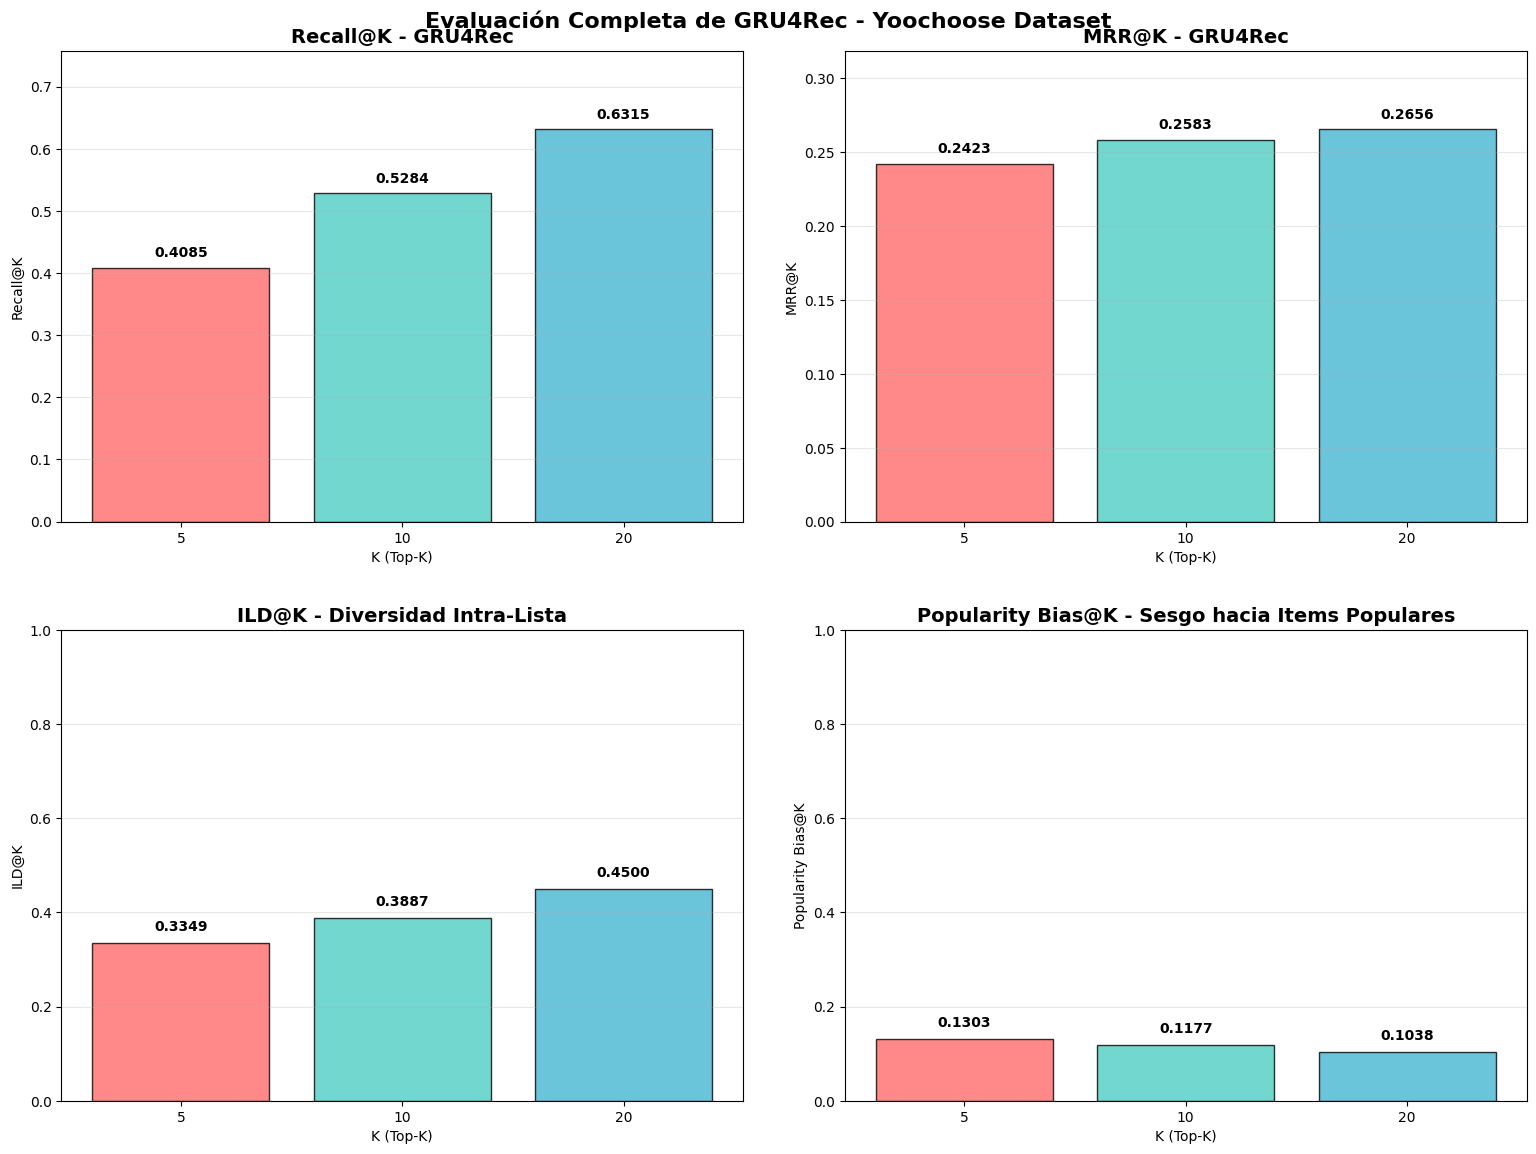

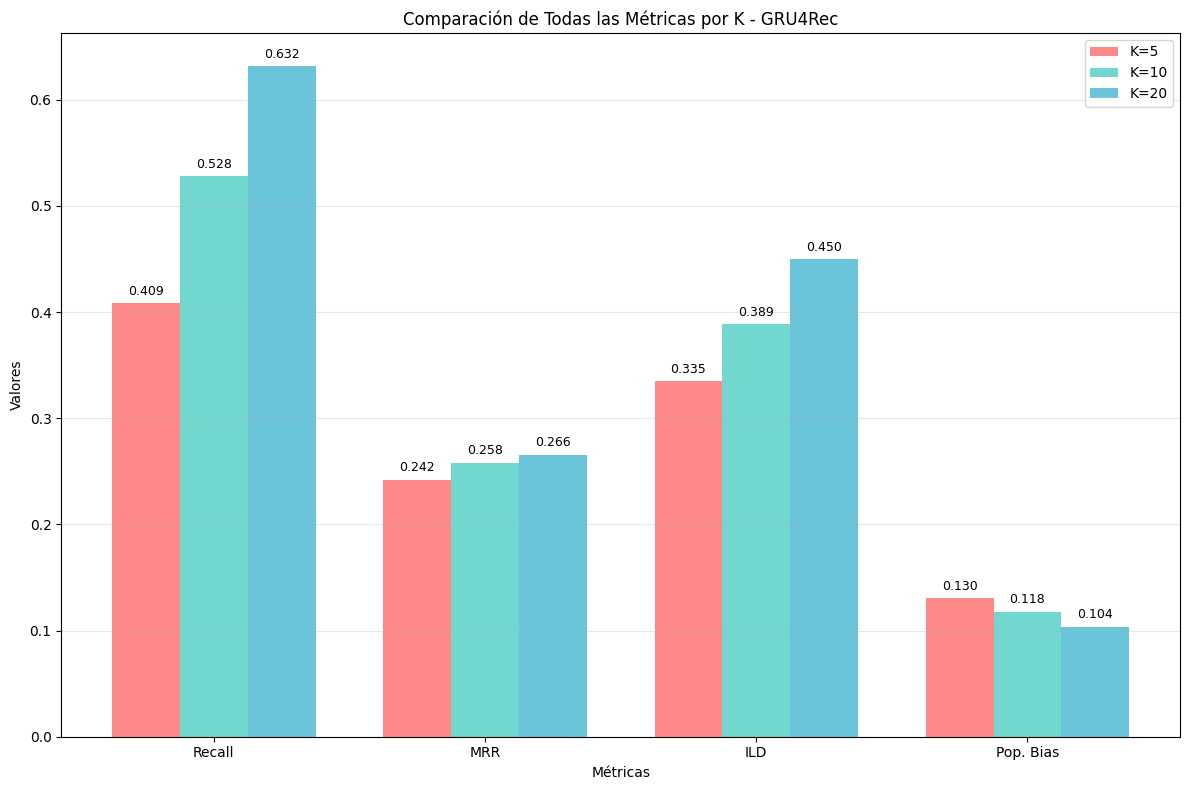


📋 TABLA DE RESUMEN - GRU4REC YOOCHOOSE
Métrica              K=5          K=10         K=20        
------------------------------------------------------------
Recall               0.4085       0.5284       0.6315      
MRR                  0.2423       0.2583       0.2656      
ILD                  0.3349       0.3887       0.4500      
Popularity Bias      0.1303       0.1177       0.1038      

📈 ANÁLISIS DE TENDENCIAS:
   🎯 Recall: Mejora al aumentar K
   📊 MRR: Mejora al aumentar K
   🌈 ILD: Mejora al aumentar K
   ⭐ Pop. Bias: Disminuye al aumentar K

🎉 VISUALIZACIÓN COMPLETADA!
   ✅ Gráficos generados exitosamente
   ✅ Análisis de tendencias realizado
   ✅ Tabla de resumen creada


In [8]:
# VISUALIZACIÓN COMPLETA DE RESULTADOS
def create_comprehensive_visualization(results):
    """Crea visualizaciones completas de las métricas de GRU4Rec"""

    # Configurar estilo
    plt.style.use('default')
    sns.set_palette("husl")

    # Crear figura con subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    k_values = [5, 10, 20]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

    # 1. Recall@K
    recall_values = [results[f'recall_{k}'] for k in k_values]
    bars1 = ax1.bar([str(k) for k in k_values], recall_values, color=colors, alpha=0.8, edgecolor='black')
    ax1.set_title('Recall@K - GRU4Rec', fontsize=14, fontweight='bold')
    ax1.set_xlabel('K (Top-K)')
    ax1.set_ylabel('Recall@K')
    ax1.set_ylim(0, max(recall_values) * 1.2)
    ax1.grid(True, alpha=0.3, axis='y')

    # Agregar valores encima de las barras
    for i, (bar, val) in enumerate(zip(bars1, recall_values)):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(recall_values) * 0.02,
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

    # 2. MRR@K
    mrr_values = [results[f'mrr_{k}'] for k in k_values]
    bars2 = ax2.bar([str(k) for k in k_values], mrr_values, color=colors, alpha=0.8, edgecolor='black')
    ax2.set_title('MRR@K - GRU4Rec', fontsize=14, fontweight='bold')
    ax2.set_xlabel('K (Top-K)')
    ax2.set_ylabel('MRR@K')
    ax2.set_ylim(0, max(mrr_values) * 1.2)
    ax2.grid(True, alpha=0.3, axis='y')

    # Agregar valores encima de las barras
    for i, (bar, val) in enumerate(zip(bars2, mrr_values)):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(mrr_values) * 0.02,
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

    # 3. ILD@K (Diversidad)
    ild_values = [results[f'ild_{k}'] for k in k_values]
    bars3 = ax3.bar([str(k) for k in k_values], ild_values, color=colors, alpha=0.8, edgecolor='black')
    ax3.set_title('ILD@K - Diversidad Intra-Lista', fontsize=14, fontweight='bold')
    ax3.set_xlabel('K (Top-K)')
    ax3.set_ylabel('ILD@K')
    ax3.set_ylim(0, 1.0)  # ILD está entre 0 y 1
    ax3.grid(True, alpha=0.3, axis='y')

    # Agregar valores encima de las barras
    for i, (bar, val) in enumerate(zip(bars3, ild_values)):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

    # 4. Popularity Bias@K
    pop_bias_values = [results[f'popularity_bias_{k}'] for k in k_values]
    bars4 = ax4.bar([str(k) for k in k_values], pop_bias_values, color=colors, alpha=0.8, edgecolor='black')
    ax4.set_title('Popularity Bias@K - Sesgo hacia Items Populares', fontsize=14, fontweight='bold')
    ax4.set_xlabel('K (Top-K)')
    ax4.set_ylabel('Popularity Bias@K')
    ax4.set_ylim(0, 1.0)  # Bias está entre 0 y 1
    ax4.grid(True, alpha=0.3, axis='y')

    # Agregar valores encima de las barras
    for i, (bar, val) in enumerate(zip(bars4, pop_bias_values)):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

    # Ajustar layout
    plt.tight_layout(pad=3.0)

    # Agregar título general
    fig.suptitle('Evaluación Completa de GRU4Rec - Yoochoose Dataset',
                fontsize=16, fontweight='bold', y=0.98)

    plt.show()

    # Crear gráfico de comparación
    plt.figure(figsize=(12, 8))

    # Datos para gráfico de líneas
    metrics = ['Recall', 'MRR', 'ILD', 'Pop. Bias']
    k5_values = [results['recall_5'], results['mrr_5'], results['ild_5'], results['popularity_bias_5']]
    k10_values = [results['recall_10'], results['mrr_10'], results['ild_10'], results['popularity_bias_10']]
    k20_values = [results['recall_20'], results['mrr_20'], results['ild_20'], results['popularity_bias_20']]

    x = np.arange(len(metrics))
    width = 0.25

    plt.bar(x - width, k5_values, width, label='K=5', color='#FF6B6B', alpha=0.8)
    plt.bar(x, k10_values, width, label='K=10', color='#4ECDC4', alpha=0.8)
    plt.bar(x + width, k20_values, width, label='K=20', color='#45B7D1', alpha=0.8)

    plt.xlabel('Métricas')
    plt.ylabel('Valores')
    plt.title('Comparación de Todas las Métricas por K - GRU4Rec')
    plt.xticks(x, metrics)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')

    # Agregar valores encima de las barras
    for i, (v5, v10, v20) in enumerate(zip(k5_values, k10_values, k20_values)):
        plt.text(i - width, v5 + 0.005, f'{v5:.3f}', ha='center', va='bottom', fontsize=9)
        plt.text(i, v10 + 0.005, f'{v10:.3f}', ha='center', va='bottom', fontsize=9)
        plt.text(i + width, v20 + 0.005, f'{v20:.3f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

# Crear visualizaciones
create_comprehensive_visualization(results)

# Crear tabla de resumen
print("\n📋 TABLA DE RESUMEN - GRU4REC YOOCHOOSE")
print("="*60)
print(f"{'Métrica':<20} {'K=5':<12} {'K=10':<12} {'K=20':<12}")
print("-" * 60)
print(f"{'Recall':<20} {results['recall_5']:<12.4f} {results['recall_10']:<12.4f} {results['recall_20']:<12.4f}")
print(f"{'MRR':<20} {results['mrr_5']:<12.4f} {results['mrr_10']:<12.4f} {results['mrr_20']:<12.4f}")
print(f"{'ILD':<20} {results['ild_5']:<12.4f} {results['ild_10']:<12.4f} {results['ild_20']:<12.4f}")
print(f"{'Popularity Bias':<20} {results['popularity_bias_5']:<12.4f} {results['popularity_bias_10']:<12.4f} {results['popularity_bias_20']:<12.4f}")
print("="*60)

# Análisis de tendencias
print(f"\n📈 ANÁLISIS DE TENDENCIAS:")
print(f"   🎯 Recall: {'Mejora' if results['recall_20'] > results['recall_5'] else 'Se mantiene'} al aumentar K")
print(f"   📊 MRR: {'Mejora' if results['mrr_20'] > results['mrr_5'] else 'Disminuye'} al aumentar K")
print(f"   🌈 ILD: {'Mejora' if results['ild_20'] > results['ild_5'] else 'Disminuye'} al aumentar K")
print(f"   ⭐ Pop. Bias: {'Aumenta' if results['popularity_bias_20'] > results['popularity_bias_5'] else 'Disminuye'} al aumentar K")

print(f"\n🎉 VISUALIZACIÓN COMPLETADA!")
print("   ✅ Gráficos generados exitosamente")
print("   ✅ Análisis de tendencias realizado")
print("   ✅ Tabla de resumen creada")


## 🔬 Análisis de Sensibilidad - Embedding Dimension

**Objetivo**: Evaluar cómo la dimensión del embedding afecta el rendimiento (Recall@20) de GRU4Rec.

Este análisis nos ayudará a entender:
- 🎯 El trade-off entre capacidad representacional y rendimiento
- 📊 El punto óptimo de embedding dimension
- ⚡ El impacto computacional de diferentes dimensiones
- 🧠 La capacidad de generalización del modelo


In [9]:
def evaluate_recall_at_k_only(model, test_loader, device, k=20):
    """
    Evaluación rápida que solo calcula Recall@K para análisis de sensibilidad
    """
    model.eval()

    recall_hits = 0
    total_predictions = 0

    with torch.no_grad():
        for input_seq, target_seq in tqdm(test_loader, desc=f"Evaluando Recall@{k}"):
            input_seq = input_seq.to(device)
            target_seq = target_seq.to(device)

            # Predicciones del modelo
            logits = model(input_seq)  # (batch_size, seq_len, vocab_size)

            # Máscara para posiciones válidas (no padding)
            mask = target_seq != 0

            # Procesar cada secuencia en el batch
            for i in range(logits.size(0)):
                seq_logits = logits[i]  # (seq_len, vocab_size)
                seq_targets = target_seq[i]  # (seq_len,)
                seq_mask = mask[i]  # (seq_len,)

                # Procesar cada posición en la secuencia
                for j in range(seq_logits.size(0)):
                    if seq_mask[j]:  # Si no es padding
                        pred_scores = seq_logits[j]  # (vocab_size,)
                        true_item = seq_targets[j].item()

                        # Obtener top-k items (excluyendo padding idx=0)
                        valid_scores = pred_scores[1:]  # Excluir padding (índice 0)
                        _, top_k_indices = torch.topk(valid_scores, k)
                        top_k_items = (top_k_indices + 1).cpu().tolist()  # +1 porque excluimos índice 0

                        # Calcular Recall@k
                        if true_item in top_k_items:
                            recall_hits += 1

                        total_predictions += 1

            # Limpieza periódica de memoria
            torch.cuda.empty_cache() if torch.cuda.is_available() else None

    recall_k = recall_hits / total_predictions if total_predictions > 0 else 0.0
    return recall_k

def sensitivity_analysis_embedding_gru4rec(train_loader, test_loader, vocab_size, device,
                                           embedding_dims=[32, 64, 128, 256], epochs=5):
    """
    Análisis de sensibilidad del embedding dimension para GRU4Rec
    """
    print("🔬 INICIANDO ANÁLISIS DE SENSIBILIDAD - EMBEDDING DIMENSION")
    print(f"   Dimensiones a probar: {embedding_dims}")
    print(f"   Epochs por modelo: {epochs} (reducido para eficiencia)")
    print(f"   Métrica: Recall@20")

    results = {}
    training_times = {}
    model_sizes = {}

    for embed_dim in embedding_dims:
        print(f"\n🎯 Probando Embedding Dimension = {embed_dim}")

        # Crear modelo con nueva dimensión
        model_test = GRU4Rec(
            num_items=vocab_size,
            embedding_dim=embed_dim,  # Variable dimension
            hidden_dim=128,
            num_layers=1,
            dropout=0.1
        ).to(device)

        # Contar parámetros
        total_params = sum(p.numel() for p in model_test.parameters())
        model_sizes[embed_dim] = total_params
        print(f"   Parámetros: {total_params:,}")

        # Entrenar modelo (epochs reducidos para eficiencia)
        start_time = time.time()

        optimizer = torch.optim.Adam(model_test.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss(ignore_index=0)

        model_test.train()
        for epoch in range(epochs):
            total_loss = 0.0
            num_batches = 0

            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} (dim={embed_dim})")

            for batch_idx, (input_seq, target_seq) in enumerate(progress_bar):
                input_seq = input_seq.to(device)
                target_seq = target_seq.to(device)

                optimizer.zero_grad()
                logits = model_test(input_seq)

                # Reshape for loss calculation
                logits = logits.reshape(-1, logits.size(-1))
                target_seq = target_seq.reshape(-1)

                loss = criterion(logits, target_seq)
                loss.backward()

                torch.nn.utils.clip_grad_norm_(model_test.parameters(), max_norm=1.0)
                optimizer.step()

                total_loss += loss.item()
                num_batches += 1

                progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})

                # Limpieza de memoria cada 50 batches
                if batch_idx % 50 == 0:
                    torch.cuda.empty_cache() if torch.cuda.is_available() else None

            avg_loss = total_loss / num_batches
            print(f"   Epoch {epoch+1} completado - Loss: {avg_loss:.4f}")

            # Limpieza de memoria al final del epoch
            gc.collect()
            torch.cuda.empty_cache() if torch.cuda.is_available() else None

        training_time = time.time() - start_time
        training_times[embed_dim] = training_time
        print(f"   Tiempo de entrenamiento: {training_time:.2f} segundos")

        # Evaluar solo Recall@20
        print(f"   Evaluando Recall@20...")
        recall_20 = evaluate_recall_at_k_only(model_test, test_loader, device, k=20)
        results[embed_dim] = recall_20

        print(f"   ✅ Embedding Dim {embed_dim}: Recall@20 = {recall_20:.4f}")

        # Limpiar modelo de memoria
        del model_test
        gc.collect()
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

    return results, training_times, model_sizes

# Ejecutar análisis de sensibilidad
print("🚀 Iniciando análisis de sensibilidad del embedding dimension para GRU4Rec...")

sensitivity_results, training_times, model_sizes = sensitivity_analysis_embedding_gru4rec(
    train_loader=train_loader,
    test_loader=test_loader,
    vocab_size=VOCAB_SIZE,
    device=device,
    embedding_dims=[32, 64, 128, 256],
    epochs=5  # Reducido para eficiencia
)

print(f"\n📊 RESULTADOS DEL ANÁLISIS DE SENSIBILIDAD - GRU4REC:")
print(f"{'Embedding Dim':<15} {'Recall@20':<12} {'Parámetros':<12} {'Tiempo (s)':<12}")
print("-" * 55)
for dim in [32, 64, 128, 256]:
    print(f"{dim:<15} {sensitivity_results[dim]:<12.4f} {model_sizes[dim]:<12,} {training_times[dim]:<12.1f}")
print("-" * 55)


🚀 Iniciando análisis de sensibilidad del embedding dimension para GRU4Rec...
🔬 INICIANDO ANÁLISIS DE SENSIBILIDAD - EMBEDDING DIMENSION
   Dimensiones a probar: [32, 64, 128, 256]
   Epochs por modelo: 5 (reducido para eficiencia)
   Métrica: Recall@20

🎯 Probando Embedding Dimension = 32
   Parámetros: 2,048,787


Epoch 1/5 (dim=32): 100%|██████████| 1308/1308 [00:07<00:00, 186.37it/s, Loss=6.2672]


   Epoch 1 completado - Loss: 7.4073


Epoch 2/5 (dim=32): 100%|██████████| 1308/1308 [00:07<00:00, 172.67it/s, Loss=8.6858]


   Epoch 2 completado - Loss: 6.5504


Epoch 3/5 (dim=32): 100%|██████████| 1308/1308 [00:06<00:00, 187.09it/s, Loss=5.7105]


   Epoch 3 completado - Loss: 5.9115


Epoch 4/5 (dim=32): 100%|██████████| 1308/1308 [00:07<00:00, 173.04it/s, Loss=5.7921]


   Epoch 4 completado - Loss: 5.4668


Epoch 5/5 (dim=32): 100%|██████████| 1308/1308 [00:07<00:00, 186.72it/s, Loss=4.9759]


   Epoch 5 completado - Loss: 5.1019
   Tiempo de entrenamiento: 37.12 segundos
   Evaluando Recall@20...


Evaluando Recall@20: 100%|██████████| 471/471 [00:11<00:00, 42.47it/s]


   ✅ Embedding Dim 32: Recall@20 = 0.5564

🎯 Probando Embedding Dimension = 64
   Parámetros: 2,455,923


Epoch 1/5 (dim=64): 100%|██████████| 1308/1308 [00:07<00:00, 168.61it/s, Loss=6.7605]


   Epoch 1 completado - Loss: 7.3215


Epoch 2/5 (dim=64): 100%|██████████| 1308/1308 [00:07<00:00, 182.26it/s, Loss=6.5296]


   Epoch 2 completado - Loss: 6.2871


Epoch 3/5 (dim=64): 100%|██████████| 1308/1308 [00:07<00:00, 166.90it/s, Loss=2.6386]


   Epoch 3 completado - Loss: 5.5935


Epoch 4/5 (dim=64): 100%|██████████| 1308/1308 [00:07<00:00, 181.59it/s, Loss=2.7172]


   Epoch 4 completado - Loss: 5.0996


Epoch 5/5 (dim=64): 100%|██████████| 1308/1308 [00:07<00:00, 170.66it/s, Loss=5.1933]


   Epoch 5 completado - Loss: 4.7033
   Tiempo de entrenamiento: 38.62 segundos
   Evaluando Recall@20...


Evaluando Recall@20: 100%|██████████| 471/471 [00:11<00:00, 42.19it/s]


   ✅ Embedding Dim 64: Recall@20 = 0.6060

🎯 Probando Embedding Dimension = 128
   Parámetros: 3,270,195


Epoch 1/5 (dim=128): 100%|██████████| 1308/1308 [00:07<00:00, 171.03it/s, Loss=6.5012]


   Epoch 1 completado - Loss: 7.2013


Epoch 2/5 (dim=128): 100%|██████████| 1308/1308 [00:07<00:00, 163.89it/s, Loss=4.8351]


   Epoch 2 completado - Loss: 6.0158


Epoch 3/5 (dim=128): 100%|██████████| 1308/1308 [00:08<00:00, 160.84it/s, Loss=6.9016]


   Epoch 3 completado - Loss: 5.3114


Epoch 4/5 (dim=128): 100%|██████████| 1308/1308 [00:07<00:00, 173.05it/s, Loss=5.1426]


   Epoch 4 completado - Loss: 4.7799


Epoch 5/5 (dim=128): 100%|██████████| 1308/1308 [00:08<00:00, 159.45it/s, Loss=3.9008]


   Epoch 5 completado - Loss: 4.3754
   Tiempo de entrenamiento: 40.53 segundos
   Evaluando Recall@20...


Evaluando Recall@20: 100%|██████████| 471/471 [00:11<00:00, 42.49it/s]


   ✅ Embedding Dim 128: Recall@20 = 0.6270

🎯 Probando Embedding Dimension = 256
   Parámetros: 4,898,739


Epoch 1/5 (dim=256): 100%|██████████| 1308/1308 [00:08<00:00, 155.84it/s, Loss=4.6717]


   Epoch 1 completado - Loss: 7.0993


Epoch 2/5 (dim=256): 100%|██████████| 1308/1308 [00:08<00:00, 147.01it/s, Loss=5.8717]


   Epoch 2 completado - Loss: 5.7944


Epoch 3/5 (dim=256): 100%|██████████| 1308/1308 [00:08<00:00, 148.92it/s, Loss=4.0959]


   Epoch 3 completado - Loss: 5.0309


Epoch 4/5 (dim=256): 100%|██████████| 1308/1308 [00:08<00:00, 148.74it/s, Loss=4.5726]


   Epoch 4 completado - Loss: 4.4787


Epoch 5/5 (dim=256): 100%|██████████| 1308/1308 [00:08<00:00, 148.53it/s, Loss=3.7342]


   Epoch 5 completado - Loss: 4.0563
   Tiempo de entrenamiento: 44.67 segundos
   Evaluando Recall@20...


Evaluando Recall@20: 100%|██████████| 471/471 [00:11<00:00, 41.35it/s]


   ✅ Embedding Dim 256: Recall@20 = 0.6466

📊 RESULTADOS DEL ANÁLISIS DE SENSIBILIDAD - GRU4REC:
Embedding Dim   Recall@20    Parámetros   Tiempo (s)  
-------------------------------------------------------
32              0.5564       2,048,787    37.1        
64              0.6060       2,455,923    38.6        
128             0.6270       3,270,195    40.5        
256             0.6466       4,898,739    44.7        
-------------------------------------------------------



📊 Creando visualizaciones del análisis de sensibilidad...


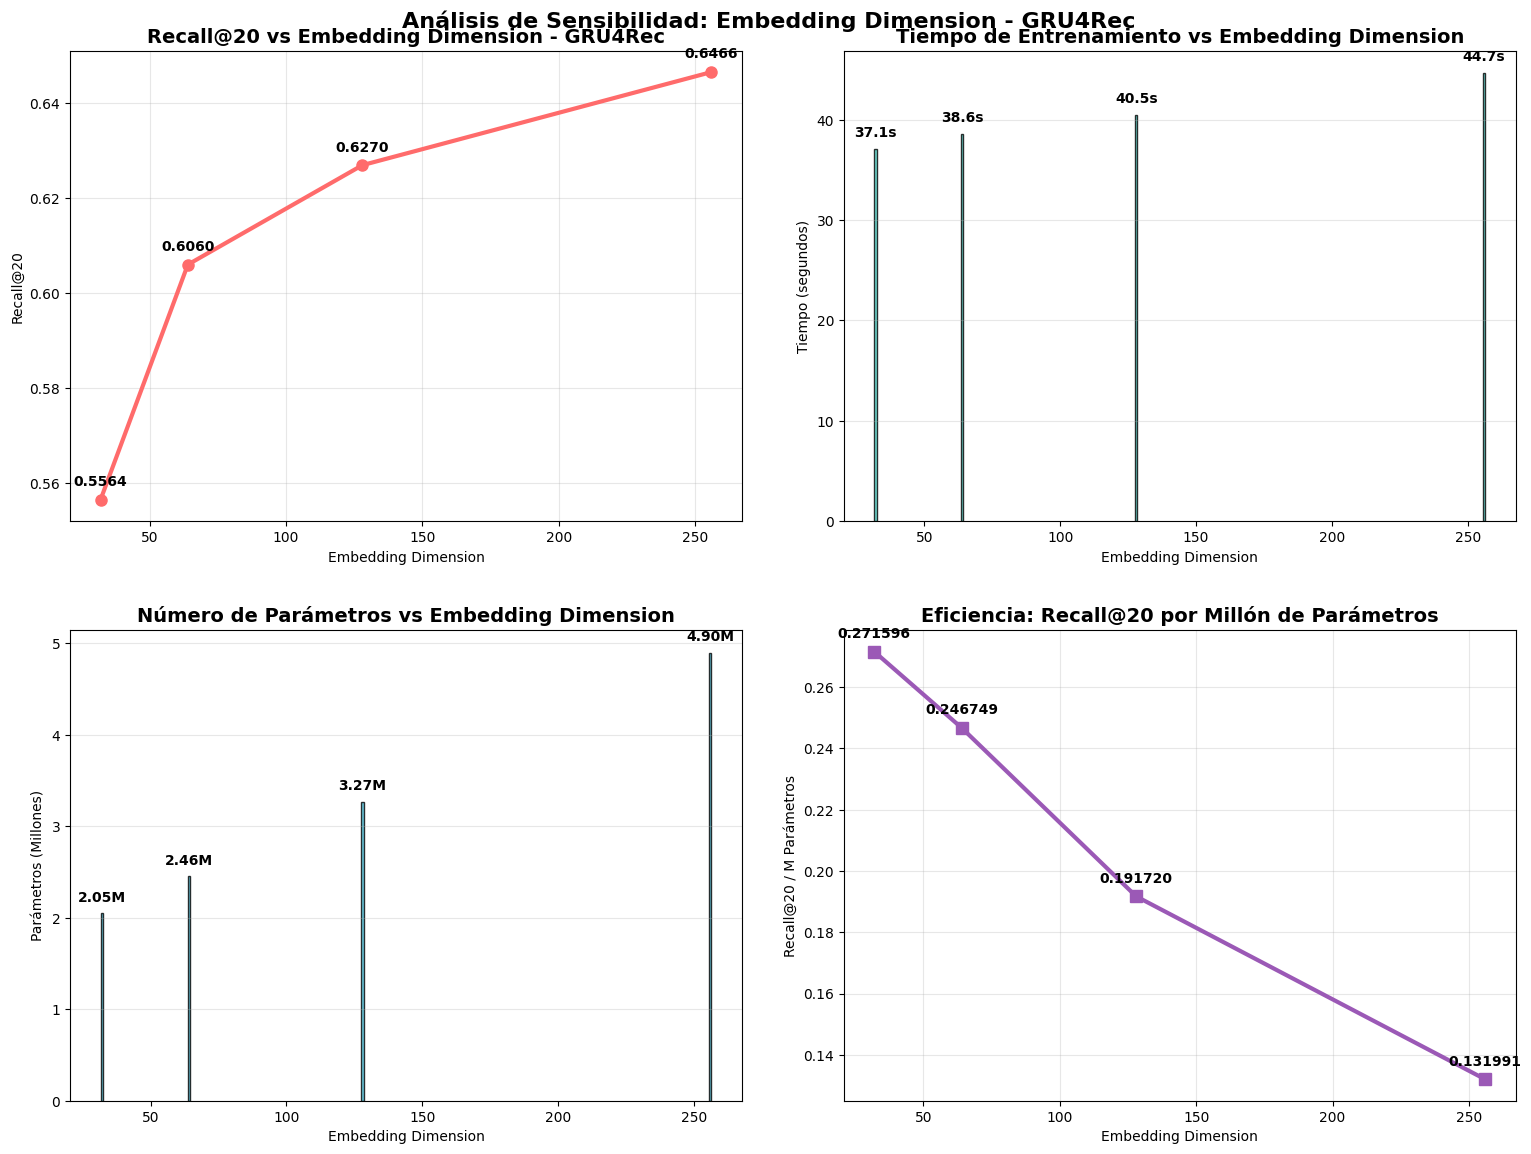


📈 ANÁLISIS ESTADÍSTICO - GRU4REC:
   🎯 Mejor Recall@20: Dimension 256 = 0.6466
   ⚡ Mejor Eficiencia: Dimension 32 = 0.271596
   📊 Mejora de 32→256: 16.2%
   💾 Costo de parámetros 32→256: 2.4x más parámetros

💾 Análisis de sensibilidad guardado en 'gru4rec_yc_sensitivity_analysis.json'
✅ Análisis de sensibilidad de GRU4Rec completado!


In [10]:
# VISUALIZACIÓN DEL ANÁLISIS DE SENSIBILIDAD - GRU4REC
def create_sensitivity_visualization_gru4rec(sensitivity_results, training_times, model_sizes):
    """Crea visualizaciones del análisis de sensibilidad de embedding dimension"""

    embedding_dims = list(sensitivity_results.keys())
    recall_values = list(sensitivity_results.values())
    time_values = list(training_times.values())
    param_values = list(model_sizes.values())

    # Crear figura con múltiples subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Recall@20 vs Embedding Dimension
    ax1.plot(embedding_dims, recall_values, 'o-', linewidth=3, markersize=8, color='#FF6B6B')
    ax1.set_title('Recall@20 vs Embedding Dimension - GRU4Rec', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Embedding Dimension')
    ax1.set_ylabel('Recall@20')
    ax1.grid(True, alpha=0.3)

    # Anotar valores
    for dim, recall in zip(embedding_dims, recall_values):
        ax1.annotate(f'{recall:.4f}', (dim, recall), textcoords="offset points",
                    xytext=(0,10), ha='center', fontweight='bold')

    # 2. Tiempo de Entrenamiento vs Embedding Dimension
    ax2.bar(embedding_dims, time_values, color='#4ECDC4', alpha=0.8, edgecolor='black')
    ax2.set_title('Tiempo de Entrenamiento vs Embedding Dimension', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Embedding Dimension')
    ax2.set_ylabel('Tiempo (segundos)')
    ax2.grid(True, alpha=0.3, axis='y')

    # Anotar valores
    for dim, time_val in zip(embedding_dims, time_values):
        ax2.text(dim, time_val + max(time_values) * 0.02, f'{time_val:.1f}s',
                ha='center', va='bottom', fontweight='bold')

    # 3. Número de Parámetros vs Embedding Dimension
    param_millions = [p/1e6 for p in param_values]
    ax3.bar(embedding_dims, param_millions, color='#45B7D1', alpha=0.8, edgecolor='black')
    ax3.set_title('Número de Parámetros vs Embedding Dimension', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Embedding Dimension')
    ax3.set_ylabel('Parámetros (Millones)')
    ax3.grid(True, alpha=0.3, axis='y')

    # Anotar valores
    for dim, param_m in zip(embedding_dims, param_millions):
        ax3.text(dim, param_m + max(param_millions) * 0.02, f'{param_m:.2f}M',
                ha='center', va='bottom', fontweight='bold')

    # 4. Eficiencia: Recall@20 / Parámetros
    efficiency = [r/p*1e6 for r, p in zip(recall_values, param_values)]
    ax4.plot(embedding_dims, efficiency, 's-', linewidth=3, markersize=8, color='#9B59B6')
    ax4.set_title('Eficiencia: Recall@20 por Millón de Parámetros', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Embedding Dimension')
    ax4.set_ylabel('Recall@20 / M Parámetros')
    ax4.grid(True, alpha=0.3)

    # Anotar valores
    for dim, eff in zip(embedding_dims, efficiency):
        ax4.annotate(f'{eff:.6f}', (dim, eff), textcoords="offset points",
                    xytext=(0,10), ha='center', fontweight='bold')

    plt.tight_layout(pad=3.0)

    # Agregar título general
    fig.suptitle('Análisis de Sensibilidad: Embedding Dimension - GRU4Rec',
                fontsize=16, fontweight='bold', y=0.98)

    plt.show()

    # Análisis estadístico
    best_recall_dim = max(sensitivity_results, key=sensitivity_results.get)
    best_efficiency_dim = embedding_dims[efficiency.index(max(efficiency))]

    print(f"\n📈 ANÁLISIS ESTADÍSTICO - GRU4REC:")
    print(f"   🎯 Mejor Recall@20: Dimension {best_recall_dim} = {sensitivity_results[best_recall_dim]:.4f}")
    print(f"   ⚡ Mejor Eficiencia: Dimension {best_efficiency_dim} = {max(efficiency):.6f}")
    print(f"   📊 Mejora de 32→256: {((sensitivity_results[256]/sensitivity_results[32])-1)*100:.1f}%")
    print(f"   💾 Costo de parámetros 32→256: {(model_sizes[256]/model_sizes[32]):.1f}x más parámetros")

    return {
        'best_recall_dim': best_recall_dim,
        'best_efficiency_dim': best_efficiency_dim,
        'efficiency_scores': efficiency
    }

# Crear visualizaciones
print("\n📊 Creando visualizaciones del análisis de sensibilidad...")
sensitivity_analysis = create_sensitivity_visualization_gru4rec(
    sensitivity_results, training_times, model_sizes
)

# Guardar resultados del análisis de sensibilidad
sensitivity_data = {
    'embedding_dimensions': [32, 64, 128, 256],
    'recall_20_scores': sensitivity_results,
    'training_times': training_times,
    'model_sizes': model_sizes,
    'analysis': sensitivity_analysis
}

import json
with open('gru4rec_yc_sensitivity_analysis.json', 'w') as f:
    json.dump(sensitivity_data, f, indent=2)

print(f"\n💾 Análisis de sensibilidad guardado en 'gru4rec_yc_sensitivity_analysis.json'")
print(f"✅ Análisis de sensibilidad de GRU4Rec completado!")
